In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()



isData = 1
if isData:
    ntupler_version = 'V1p17/'
    analyzer_version = "/v5/v87/"
    analyzer_version = "/v5/v95/"
    analyzer_version = "/v5/v98/"
    analyzer_version = "/v5/v99/"
    analyzer_version = "/v5/v100/"





    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
    
    fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
    
    
    
    fpath_bkg['data18'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2017/'+analyzer_version+'/normalized/'
    fpath_bkg['data17'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
    data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2016/'+analyzer_version+'/normalized/'
    fpath_bkg['data16'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'



    

else:
    ntupler_version = 'V1p17/'
    analyzer_version = "/v1/v86/"
#     analyzer_version = "/v1/v95/"
    analyzer_version = "/v1/v100/"
    analyzer_version = "/v1/v108/" #new acceptance definition

    analyzer_version = "/v1/v110/" #new acceptance definition and no cuts at all




    mass = '55'
    lumi = [ 35.9, 41.5, 59.7 ]
    years = ['MC_Summer16', 'MC_Fall17', 'MC_Fall18']
    ctaus  = ['100','1000','10000','100000']

    for ct in ctaus:
        mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
        fpath_bkg['m'+mass+'ctau'+ct] = mc_path + 'ggH_HToSSTobbbb_MH-125_MS-'+str(mass)+'_ctau-'+ct+'_137000pb_weighted.root'
# fpath_bkg['ttH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v1/v90//normalized/ttH_HToSS_SToBB_ms40_pl1000_137000pb_weighted.root'
# fpath_bkg['ggZH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v2/v90//normalized/ggZHToSS_SToBB_ms40_pl1000_137000pb_weighted.root'
# fpath_bkg['ZH'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_Fall18/v1/v90//normalized/ZHToSS_SToBB_ms40_pl1000_137000pb_weighted.root'

# h_reweight= {}
# v = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ttHToggZH_HiggsPtReweight.root'
# root_dir = uproot.open(v) 
# h_reweight['ttH'] = root_dir['higgsPt']
# v = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root'
# root_dir = uproot.open(v) 
# h_reweight['ZH'] = root_dir['higgsPt']
NEvents = {}
Total = {}
accep = {}
accep_met = {}
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    if not isData:
#         Total[k] = root_dir['Total'][1]
        Total[k] = root_dir['Total'][1]


        accep[k] = root_dir['acceptance'][1]
        accep_met[k] = root_dir['acceptance_met'][1]
#     else:
#         Nmet200 = root_dir['Nmet200'][1]
#         NmetFilter = root_dir['NmetFilter'][1]
#         Nlep0 = root_dir['Nlep0'][1]
#         Njet1 = root_dir['Njet1'][1]
#         NcosmicVeto = root_dir['NcosmicVeto'][1]
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k],len(a))


data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2018//v5/v100//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0 14129474
data18 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2018//v5/v100//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root
NEvents 12243668.0 8260035
data17 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2017//v5/v100//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root
NEvents 5003147.0 3454493
data16 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2016//v5/v100//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_goodLumi.root
NEvents 5516435.0 2414946


# load bdt

In [3]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12'
# bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2'

# model = pickle.load(open( bdt_name+'.pickle', "rb" ))
# y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
# print (y_pred)
# BDT_CUT = 0.50882477 

# background cut flow

In [9]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
cut_based = True
cut_based_version="v4"

intime = True
DPHI_CUT = 1
cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterEta = {}
sel_ev = {}
weight = {}
dphiMet_cluster = {}
bdt_sel = {}
Nrechits = {}
ncluster = 1
cluster_index = '3'
table = OrderedDict()

table['met'] = "Trigger and MET cut "
table['met_filter'] = "MET filters "
table['lep'] = "$N_{lepton} = 0$ "
table['jet'] = r"$N_{jet} \geq 1$ "
table['cosmic_veto'] = r"$N_{\text{CSC+DT rings}} \leq 10 $ "
table['1_cluster'] = "$N_{cluster} \geq 1$ "

table['muon_veto'] = "muon veto "
table['jet_veto'] = "jet veto "
table['time'] = "Time cut "
table['me11'] = "ME1/1 veto "
table['me12'] = "ME1/2 veto "
table['re12'] = "RE1/2 veto "
table['mb1'] = "MB1 veto "
table['rb1'] = "RB1 veto "
table['eta'] = r"$\eta$ cut "
table['time_spread'] = "time spread cut "
table['1_cluster_req'] = "$N_{cluster} = 1$ "



if cut_based: table['bdt'] = "cut-based ID "
else: table['bdt'] = "BDT cut "
table['dphi'] = r"$\Delta\phi\mathrm{ (cluster,MET)}$ "
table['nrechits'] = r"$N_{rechits}$ cut "

for k, T in tree_bkg.items():
    if not k == 'data18':continue
    weight = T.array('weight')*0.0+1.0
    print(weight[:10], len(weight))
    ########### SELECTION: JETS ############

    sel_jet = np.logical_and(T.array('jetPt') >= jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

    ########### SELECTION: EVENTS ############
    NEvents[k] = len(weight)
    sel_ev[k] = np.logical_and(T.array('metEENoise')>=200 ,T.array('METNoMuTrigger'))
    print(len(sel_ev[k]),np.count_nonzero(sel_ev[k]))
    print("trigger + MET", np.count_nonzero(sel_ev[k])/NEvents[k], np.count_nonzero(sel_ev[k])/NEvents[k])
    table["met"] += " & {0:6.3f} & {1:6.3f} & {2:6.0f}".format(100* np.count_nonzero(sel_ev[k])/NEvents[k], 100* np.count_nonzero(sel_ev[k])/NEvents[k], np.count_nonzero(sel_ev[k]))



    acc_met = np.count_nonzero(sel_ev[k])
    sel_temp = np.count_nonzero(sel_ev[k])


    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('Flag2_all') == 1)
    print("MET filters", np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["met_filter"] += " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.count_nonzero(sel_ev[k])/sel_temp, 100*np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k]))




    sel_temp = np.count_nonzero(sel_ev[k])


    sel_ev[k]  = np.logical_and(sel_ev[k], np.logical_and(T.array('category') == 0, T.array('nLeptons') == 0))
    print("0 lepton", np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["lep"] += " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.count_nonzero(sel_ev[k])/sel_temp, 100*np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k]))

    sel_temp = np.count_nonzero(sel_ev[k])


    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    print("1 jet", np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["jet"] += " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.count_nonzero(sel_ev[k])/sel_temp, 100*np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k]))

    sel_temp = np.count_nonzero(sel_ev[k])


    sel_ev[k] = np.logical_and(sel_ev[k] , T.array("nDtRings")+T.array("nCscRings") < 10)
    print("cosmic shower veto", np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["cosmic_veto"] += " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.count_nonzero(sel_ev[k])/sel_temp, 100*np.count_nonzero(sel_ev[k])/acc_met, np.count_nonzero(sel_ev[k]))

    sel_temp = np.count_nonzero(sel_ev[k])



    ########### SELECTION: CLUSTERS ############

#     binD = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'Size')>=130, np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))<0.75)
    binD = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'Size')>=130, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<0.75)
    binD = T.array('cscRechitCluster' + cluster_index + 'Size')<0 #for unblinding



    sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + 'Size')>=50
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_not(binD))
#     sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)
    print("cluster efficiency", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    
    table["1_cluster"] +=  " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                     np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))  
#     table["1_cluster"] +=  " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                          
                          
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])




    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("muon cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["muon_veto"] +=  " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                     np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))   
#     table["muon_veto"] +=  " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                           
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("jet cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["jet_veto"] +=   " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                     np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))       
#     table["jet_veto"] +=   " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                              
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
    
    #     sel_rechitcluster = np.logical_and( sel_rechitcluster, np.logical_or(T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT,\
#                               T.array('cscRechitCluster' + cluster_index + 'MuonVetoLooseId') == 0))

 
    
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("time cut", np.sum([np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["time"] +=  " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))   
#     table["time"] +=  " & {0:6.2f} & {1:6.2f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                          
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
    
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("ME11", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["me11"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))   
#     table["me11"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                            
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("ME12", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["me12"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))   
#     table["me12"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                          
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



    


    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("re12 cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["re12"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))     
#     table["re12"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                          
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])


    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("mb1 cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["mb1"] +=   " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))       
#     table["mb1"] +=   " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                                
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
    
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("rb1 cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["rb1"] +=   " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))   
#     table["rb1"] +=   " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                          
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
   

    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("eta cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["eta"] +=   " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))     
#     table["eta"] +=   " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                               
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])

    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') < 20)
    sel_cluster_temp = np.logical_and(sel_ev[k], np.logical_and(sel_rechitcluster, np.logical_not(binD)).sum()>=1)

    print("time spread cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["time_spread"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met,\
                                                                       np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)]))        
#     table["time_spread"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_cluster_temp])/sel_temp,\
#                                                       100*np.sum(weight[sel_cluster_temp])/acc_met,\
#                                                                      np.sum(weight[sel_cluster_temp]))  
                             
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])


########### BRANCHES ############

   ##### event variables ##### 

    sel_ev[k] = np.logical_and(sel_ev[k], sel_rechitcluster.sum()==1)
    print("1 cluster", np.sum(weight[sel_ev[k]])/acc_met, np.sum(weight[sel_ev[k]])/sel_temp)
    table["1_cluster_req"] +=  " & {0:6.2f} & {1:6.3f} & {2:6.0f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp,\
                                                      100*np.sum(weight[sel_ev[k]])/acc_met,\
                                                                       np.sum(weight[sel_ev[k]]))  
    sel_temp = np.sum(weight[sel_ev[k]])


#     ##### bdt variables ####

    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    if len(cscRechitClusterAvgStation10[k]>0):
        if not cut_based:
            dataset = pd.DataFrame(bdt_var)
            bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
            bdt_sel[k] = bdt_score[k] >= BDT_CUT 
            print("bdt", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
        else:
            if cut_based_version == 'v4':
                cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
                cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
                cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
                bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))

                print("cut based", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)


                bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            else:print("CUTBASED ERROR")
        dphiMet_cluster[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        Nrechits[k] = np.abs(T.array('cscRechitCluster' + cluster_index + 'Size'))[sel_rechitcluster][sel_ev[k]][:,0].flatten()
        binD = np.logical_and(dphiMet_cluster[k]<0.75, Nrechits[k]>=130)

        sel_cluster_temp = np.logical_and(bdt_sel[k], np.logical_not(binD))
#         table["bdt"] += " & {0:6.2f} & {1:6.3f}& {2:6.0f}".format(100*np.sum(weight[sel_ev[k]][sel_cluster_temp])/sel_temp, 100*np.sum(weight[sel_ev[k]][sel_cluster_temp])/acc_met,\
#                                                         np.sum(weight[sel_ev[k]][sel_cluster_temp]))
        table["bdt"] += " & {0:6.2f} & {1:6.3f}& {2:6.0f}".format(100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met,\
                                                        np.sum(weight[sel_ev[k]][bdt_sel[k]]))
        sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])

#         dphi[k] = np.abs(T.array('jetMet_dPhiMin'))[sel_ev[k]][bdt_sel[k]]




#         bdt_sel[k] = np.logical_and(bdt_sel[k], np.abs(T.array('jetMet_dPhiMin')[sel_ev[k]])<0.6)
#         bdt_sel[k] = np.logical_and(bdt_sel[k], np.abs(T.array('cscRechitCluster' + cluster_index + 'Met_dPhi')[sel_rechitcluster][sel_ev[k]][:,0])<0.75)
        bdt_sel[k] = np.logical_and(bdt_sel[k], np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_rechitcluster][sel_ev[k]][:,0])<0.75)
        print("dphi cut", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
        table["dphi"] += " & {0:6.2f} & {1:6.4f}& {2:6.0f}".format(100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp, \
                                                         100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met,  np.sum(weight[sel_ev[k]][bdt_sel[k]]))
        print(T.array('evtNum')[sel_ev[k]][bdt_sel[k]])
        sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])

        bdt_sel[k] = np.logical_and(bdt_sel[k], np.abs(T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][:,0])>=130)
        print("nrechits cut", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
        table["nrechits"] += " & {0:6.2f} & {1:6.5f}& {2:6.0f}".format(100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp, \
                                                                       100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]]))
        sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])
        print('signal yield', np.sum(weight[sel_ev[k]][bdt_sel[k]]))

#         bdt_sel[k] = np.logical_and(bdt_sel[k], (T.array('nDTRechitsChamberMinus41')+T.array('nDTRechitsChamberMinus41')+T.array('nDTRechitsChamber40')+\
#         T.array('nDTRechitsChamberPlus41')+T.array('nDTRechitsChamberPlus42'))[sel_ev[k]]<40)
#         print("DTrechits cut", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
#         sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])



    else:
        table["bdt"] += " & {0:6.2f} & {1:6.2f}".format(0.0, 0.0)
        table["dphi"] += " & {0:6.2f} & {1:6.2f}".format(0.0, 0.0)
        table["nrechits"] += " & {0:6.2f} & {1:6.2f}".format(0.0, 0.0)





for k,v in table.items():
    print(v+r" \\")



[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 8260035
8260035 8260035
trigger + MET 1.0 1.0
MET filters 0.9439945472386013 0.9439945472386013 7797428
0 lepton 0.878966856677968 0.931114336676145 7260297
1 jet 0.6845523051657771 0.7788146958726344 5654426
cosmic shower veto 0.6845523051657771 1.0 5654426
cluster efficiency 0.06647320501668577 0.09710463979898225
muon cut 0.04068844744604593 0.612103
jet cut 0.01829495879860073 0.4496352
time cut 0.004664871274758521 0.25498125
ME11 0.0005127096919080852 0.10990865
ME12 0.0002383767139001227 0.46493506
re12 cut 0.00023643967610306735 0.99187404
mb1 cut 0.00023268666537127263 0.984127
rb1 cut 0.00023208134105969283 0.99739856
eta cut 5.157363134659841e-05 0.22222222
time spread cut 3.692478300636741e-05 0.71596247
1 cluster 3.692478300636741e-05 1.0
cut based 1.0532643021488408e-05 0.2852459
dphi cut 2.78449183326705e-06 0.26436782
[ 680397939  834454170  292396821  903122419  846238946  185317501
 2633219121  410880276 1362289194  599300884  650407747

In [ ]:
16
Trigger and MET cut  & 100.000 & 100.000 & 2414946 \\
MET filters  &  89.79 &  89.79 & 2168274 \\
$N_{lepton} = 0$  &  87.30 &  78.38 & 1892923 \\
$N_{jet} \geq 1$  &  94.71 &  74.23 & 1792717 \\
$N_{\text{CSC+DT rings}} \leq 10 $  & 100.00 &  74.23 & 1792682 \\
$N_{cluster} \geq 1$  &   5.06 &   3.75 &  90639 \\
muon veto  &  56.49 &   2.12 &  51202 \\
jet veto  &  51.01 &   1.08 &  26118 \\
Time cut  &  29.98 &   0.32 &   7830 \\
ME1/1 veto  &  15.94 &  0.052 &   1248 \\
ME1/2 veto  &  42.55 &  0.022 &    531 \\
RE1/2 veto  &  99.25 &  0.022 &    527 \\
MB1 veto  &  97.15 &  0.021 &    512 \\
RB1 veto  &  99.41 &  0.021 &    509 \\
$\eta$ cut  &  18.07 &  0.004 &     92 \\
time spread cut  &  73.91 &  0.003 &     68 \\
$N_{cluster} = 1$  & 100.00 &  0.003 &     68 \\
cut-based ID  &  35.29 &  0.001&     24 \\
$\Delta\phi\mathrm{ (cluster,MET)}$  &  41.67 & 0.0004&     10 \\
$N_{rechits}$ cut  &  10.00 & 0.00004&      1 \\

17
Trigger and MET cut  & 100.000 & 100.000 & 3454493 \\
MET filters  &  90.34 &  90.34 & 3120841 \\
$N_{lepton} = 0$  &  89.86 &  81.18 & 2804332 \\
$N_{jet} \geq 1$  &  78.92 &  64.07 & 2213129 \\
$N_{\text{CSC+DT rings}} \leq 10 $  & 100.00 &  64.06 & 2213119 \\
$N_{cluster} \geq 1$  &   6.06 &   3.88 & 134078 \\
muon veto  &  67.10 &   2.60 &  89960 \\
jet veto  &  53.70 &   1.40 &  48307 \\
Time cut  &  28.06 &   0.39 &  13556 \\
ME1/1 veto  &  12.67 &  0.050 &   1718 \\
ME1/2 veto  &  45.98 &  0.023 &    790 \\
RE1/2 veto  &  99.37 &  0.023 &    785 \\
MB1 veto  &  98.09 &  0.022 &    770 \\
RB1 veto  &  99.74 &  0.022 &    768 \\
$\eta$ cut  &  20.31 &  0.005 &    156 \\
time spread cut  &  80.77 &  0.004 &    126 \\
$N_{cluster} = 1$  & 100.00 &  0.004 &    126 \\
cut-based ID  &  30.16 &  0.001&     38 \\
$\Delta\phi\mathrm{ (cluster,MET)}$  &  44.74 & 0.0005&     17 \\
$N_{rechits}$ cut  &   0.00 & 0.00000&      0 \\

18
Trigger and MET cut  & 100.000 & 100.000 & 8260035 \\
MET filters  &  94.40 &  94.40 & 7797428 \\
$N_{lepton} = 0$  &  93.11 &  87.90 & 7260297 \\
$N_{jet} \geq 1$  &  77.88 &  68.46 & 5654426 \\
$N_{\text{CSC+DT rings}} \leq 10 $  & 100.00 &  68.46 & 5654426 \\
$N_{cluster} \geq 1$  &   9.71 &   6.65 & 549071 \\
muon veto  &  61.21 &   4.07 & 336088 \\
jet veto  &  44.96 &   1.83 & 151117 \\
Time cut  &  25.50 &   0.47 &  38532 \\
ME1/1 veto  &  10.99 &  0.051 &   4235 \\
ME1/2 veto  &  46.49 &  0.024 &   1969 \\
RE1/2 veto  &  99.19 &  0.024 &   1953 \\
MB1 veto  &  98.41 &  0.023 &   1922 \\
RB1 veto  &  99.74 &  0.023 &   1917 \\
$\eta$ cut  &  22.22 &  0.005 &    426 \\
time spread cut  &  71.60 &  0.004 &    305 \\
$N_{cluster} = 1$  & 100.00 &  0.004 &    305 \\
cut-based ID  &  28.52 &  0.001&     87 \\
$\Delta\phi\mathrm{ (cluster,MET)}$  &  26.44 & 0.0003&     23 \\
$N_{rechits}$ cut  &   8.70 & 0.00002&      2 \\

# signal cut flow

In [6]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
cut_based = True
cut_based_version="v4"

# BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
# bdtBkgEff =  0.0661076084960519

# BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
# bdtBkgEff =  0.10278372591006424
if bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs':
    BDT_CUT = 0.92245656 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs
    bdtBkgEff = 0.09957173447537473
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi':
    BDT_CUT = 0.9608465 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.06745182012847965
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2':
    BDT_CUT = 0.7802247 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.061027837259100645
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v5':
    BDT_CUT = 0.76344216 #bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi
    bdtBkgEff = 0.051208285385500575
elif bdt_name == 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v12':
    BDT_CUT = 0.50882477 
    bdtBkgEff = 0.18136439267886856
    BDT_BINS = [0.0, BDT_CUT]
    BDT_BINS = [0.0, 0.1]
#     BDT_BINS = [0.0, 0.1, 0.2, BDT_CUT]
    
else:
    print('BDT NAME NOT FOUND')

intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}
cscRechitClusterXYSpread = {}
cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}
cscRechitCluster_match_gLLP_index = {}
cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterAvgStation = {}
cscRechitClusterMet_dPhi = {}
cscRechitCluster2_match_Me1112_0p8 = {}
jetMet_dPhiMin30 = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
gLLP_decay_vertex_z = {}
gLLP_decay_vertex_x = {}
gLLP_decay_vertex_y = {}
gLLP_decay_vertex_r = {}
ctau = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
bdt_sel = {}
gHiggsPt = {}
gLLP_pt = {}
gLLP2_pt = {}
gLLP2_decay_vertex_r = {}
gLLP2_decay_vertex_z = {}
cscRechitCluster2_match_gLLP_decay_z = {}
cscRechitCluster2_match_gLLP_decay_r = {}
gParticleId = {}
gParticlePt = {}
cscRechitCluster_match_gLLP_decay_r = {}
cscRechitCluster_match_gLLP_decay_z = {}
trigger_bits = {}
# keys = ['mc_sr']
dphi = {}
ncluster = 1
cluster_index = '3'
table = OrderedDict()
table['acc'] = "Acceptance "
table['met'] = "Trigger and MET cut "
table['met_filter'] = "MET filters "



table['lep'] = "$N_{lepton} = 0$ "
table['jet'] = r"$N_{jet} \geq 1$ "
table['cosmic_veto'] = r"$N_{\text{CSC+DT rings}} \leq 10 $ "
table['1_cluster'] = "$N_{cluster} \geq 1$ "

table['muon_veto'] = "muon veto "
table['jet_veto'] = "jet veto "
table['time'] = "Time cut "
table['me11'] = "ME1/1 veto "
table['me12'] = "ME1/2 veto "
table['re12'] = "RE1/2 veto "
table['mb1'] = "MB1 veto "
table['rb1'] = "RB1 veto "
table['eta'] = r"$\eta$ cut "
table['time_spread'] = "time spread cut "
table['1_cluster_req'] = "$N_{cluster} = 1$ "

if cut_based: table['bdt'] = "cut-based ID "
else: table['bdt'] = "BDT cut "
table['dphi'] = r"$\Delta\phi\mathrm{ (cluster,MET)}$ "
table['nrechits'] = r"$N_{rechits}$ cut "

for k, T in tree_bkg.items():
    if k == 'm55ctau100':continue
    weight = T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF')
    print(weight[:10])

#     if not k == 'ggZH':
#         weight = weight*h_reweight[k].values[np.argmax(h_reweight[k].edges>T.array('gHiggsPt')[:,None],axis=1)-1]
#     print(weight[:10])
    ########### SELECTION: JETS ############

    sel_jet = np.logical_and(T.array('jetPt') >= jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()

    sel_ev[k] = np.sum(T.array('gLLP_csc'),axis = 1) >= 1
    acceptance = np.sum(T.array('weight')[sel_ev[k]])
#     total = np.sum(T.array('weight'))
    
#     acceptance = accep[k]
#     total = np.sum(weight_nomet)
    total = np.sum(T.array('weight'))
#     total = Total[k]
#     total = NEvents[k]
    print("acceptance", acceptance/total, np.count_nonzero(sel_ev[k]))
#     table['acc'] = table['acc']+str(acceptance/total)+" &"
    table["acc"] += " & {0:6.3f} & {1:6.3f}".format(100*acceptance/total,100*acceptance/total)

    
    
    
    sel_temp = np.sum(T.array('weight')[sel_ev[k]])
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('METNoMuTrigger'))
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met')>=200)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise')>=200)

    accep_met[k] = np.sum(weight[sel_ev[k]])
    print("trigger + MET", accep_met[k]/acceptance, np.sum(weight[sel_ev[k]])/sel_temp, accep_met[k]/total,np.count_nonzero(sel_ev[k]))
#     table["met"] += " & "+str(np.sum(T.array('weight')[sel_ev[k]])/acceptance)+" & "+str(np.sum(T.array('weight')[sel_ev[k]])/total)
#     table["met"] += " & {0:6.3f} & {1:6.3f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]])/total)
    table["met"] += " & {0:6.3f} & {1:6.3f}".format(100*accep_met[k]/acceptance, 100*accep_met[k]/total)
#     table["met"] += " & {0:6.3f} & {1:6.3f}".format(100*np.sum(weight[sel_ev[k]])/acceptance, 100*np.sum(weight[sel_ev[k]])/total)






    acc_met = np.sum(weight[sel_ev[k]])
    sel_temp = np.sum(weight[sel_ev[k]])


    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('Flag2_all') == 1)
    print("MET filters", np.sum(weight[sel_ev[k]])/acc_met, np.sum(weight[sel_ev[k]])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["met_filter"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]])/acc_met)



    sel_temp = np.sum(weight[sel_ev[k]])


    sel_ev[k]  = np.logical_and(sel_ev[k], np.logical_and(T.array('category') == 0, T.array('nLeptons') == 0))
    print("0 lepton", np.sum(weight[sel_ev[k]])/acc_met, np.sum(weight[sel_ev[k]])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["lep"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]])/acc_met)

    sel_temp = np.sum(weight[sel_ev[k]])


    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    print("1 jet", np.sum(weight[sel_ev[k]])/acc_met, np.sum(weight[sel_ev[k]])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["jet"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]])/acc_met)

    sel_temp = np.sum(weight[sel_ev[k]])


    sel_ev[k] = np.logical_and(sel_ev[k] , T.array("nDtRings")+T.array("nCscRings") < 10)
    print("cosmic shower veto", np.sum(weight[sel_ev[k]])/acc_met, np.sum(weight[sel_ev[k]])/sel_temp,np.count_nonzero(sel_ev[k]))
    table["cosmic_veto"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]])/acc_met)

    sel_temp = np.sum(weight[sel_ev[k]])



    ########### SELECTION: CLUSTERS ############

    sel_rechitcluster = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc')
    print("cluster efficiency", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["1_cluster"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)  

    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])


#     sel_rechitcluster = np.logical_and( sel_rechitcluster, np.logical_or(T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT,\
#                               T.array('cscRechitCluster' + cluster_index + 'MuonVetoLooseId') == 0))


   

    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    print("jet cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["jet_veto"] +=   " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)       
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
    
    
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    print("muon cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["muon_veto"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)   
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    print("time cut", np.sum([np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["time"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)   
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])





    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    print("ME11", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["me11"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)   
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    print("ME12", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["me12"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)   
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])


    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    print("re12 cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["re12"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)     
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])


    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    print("mb1 cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["mb1"] +=   " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)       
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])
    
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    print("rb1 cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["rb1"] +=   " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)   
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])



    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0)
    print("eta cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["eta"] +=   " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)     
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])


    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') < 20)
    print("time spread cut", np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met, np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp)
    table["time_spread"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/sel_temp,\
                                                      100*np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])/acc_met)        
    sel_temp = np.sum(weight[np.logical_and(sel_ev[k], sel_rechitcluster.sum()>=1)])




########### BRANCHES ############

   ##### event variables ##### 

    sel_ev[k] = np.logical_and(sel_ev[k], sel_rechitcluster.sum()==1)
    print("1 cluster", np.sum(weight[sel_ev[k]])/acc_met, np.sum(weight[sel_ev[k]])/sel_temp)
    table["1_cluster_req"] +=  " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]])/sel_temp,\
                                                      100*np.sum(weight[sel_ev[k]])/acc_met)
    sel_temp = np.sum(weight[sel_ev[k]])


#     ##### bdt variables ####

    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation[k] = T.array('cscRechitCluster' + cluster_index + 'NStation5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
   
    if len(cscRechitClusterEta[k]>0):
        if not cut_based:
            dataset = pd.DataFrame(bdt_var)
            bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
            bdt_sel[k] = bdt_score[k] >= BDT_CUT 
            print("bdt", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
        else:
            if cut_based_version == 'v4':
                cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
                cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
                cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
                cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
                bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))

                print("cut based", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)


                bdt_sel[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
            else:print("CUTBASED ERROR")
        table["bdt"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met)
        sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])


        bdt_sel[k] = np.logical_and(bdt_sel[k], np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_rechitcluster][sel_ev[k]][:,0])<0.75)
        print("dphi cut", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
        table["dphi"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met)
        sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])
        
        bdt_sel[k] = np.logical_and(bdt_sel[k], np.abs(T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]][:,0])>=130)
        print("nrechits cut", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
        table["nrechits"] += " & {0:6.2f} & {1:6.2f}".format(100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp, 100*np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met)
        sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])
        print('signal yield', sel_temp, np.count_nonzero(bdt_sel[k]))


#         bdt_sel[k] = np.logical_and(bdt_sel[k], (T.array('nDTRechitsChamberMinus41')+T.array('nDTRechitsChamberMinus41')+T.array('nDTRechitsChamber40')+\
#         T.array('nDTRechitsChamberPlus41')+T.array('nDTRechitsChamberPlus42'))[sel_ev[k]]<40)
#         print("DTrechits cut", np.sum(weight[sel_ev[k]][bdt_sel[k]])/acc_met, np.sum(weight[sel_ev[k]][bdt_sel[k]])/sel_temp)
#         sel_temp =  np.sum(weight[sel_ev[k]][bdt_sel[k]])

        

    else:
        table["bdt"] += " & {0:6.2f} & {1:6.2f}".format(0.0, 0.0)
        table["dphi"] += " & {0:6.2f} & {1:6.2f}".format(0.0, 0.0)
        table["nrechits"] += " & {0:6.2f} & {1:6.2f}".format(0.0, 0.0)








for k,v in table.items():
    print(v+r" \\")


[3.7263558  1.325345   0.42801812 0.5289068  3.6116161  3.5544662
 1.4215338  0.6828507  2.2638125  1.7498852 ]
acceptance 0.07784231 545555
trigger + MET 0.015848808 0.015848808 0.0012337079 9364
MET filters 0.95463204 0.95463204 8896
0 lepton 0.9494391 0.9945603 8843
1 jet 0.91267884 0.96128213 8523
cosmic shower veto 0.91267884 1.0 8523
cluster efficiency 0.7139652 0.78227425
jet cut 0.47389805 0.6637552
muon cut 0.44348994 0.93583405
time cut 0.4820555232401406 0.9971179
ME11 0.32365292 0.7318958
ME12 0.20860885 0.6445449
re12 cut 0.20459205 0.98074484
mb1 cut 0.19581127 0.95708156
rb1 cut 0.19116843 0.97628915
eta cut 0.13051002 0.6826965
time spread cut 0.12871866 0.9862741
1 cluster 0.12850337 0.99832743
cut based 0.1055852 0.8216532
dphi cut 0.10541843 0.9984205
nrechits cut 0.09546151 0.90554863
signal yield 784.9914 854
[0.5978597  0.2640405  1.9672872  0.38299596 1.6359088  0.51532584
 1.9765246  0.39172083 0.21783498 1.405975  ]
acceptance 0.23628637 1647714
trigger + MET 0

# cut efficiency for each cut wrt. LLP decay position

In [3]:
%%time
import uproot
import numpy as np
cut_based = True
cut_based_version='v4'
r_denom = {}
z_denom = {}
r_nom = {}
z_nom = {}
r_nRechits = {}
z_nRechits = {}
weight_nom = {}
weight_denom = {}
weight_nRechits = {}
llp_r = {}
llp_z = {}
weight_llp = {}

m = '55'
lumi = [ 35.9, 41.5, 59.7 ]
for m in ['15', '40','55']:
    r_denom[m] = []
    z_denom[m] = []
    r_nom[m] = []
    z_nom[m] = []
    r_nRechits[m] = []
    z_nRechits[m] = []
    weight_nom[m] = []
    weight_denom[m] = []
    weight_nRechits[m] = []
    llp_r[m] = []
    llp_z[m] =[]
    weight_llp[m] = []
    for i, year in enumerate(["MC_Summer16", "MC_Fall17", "MC_Fall18"]):
        analyzer_version = "/v1/v108/"
        path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/"+year+analyzer_version+"normalized/"
        root_dir =uproot.open(path+"ggH_HToSSTobbbb_MH-125_MS-"+m+".root")
        T = root_dir['MuonSystem']
        sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
        ########### SELECTION: EVENTS ############
        hlt = T['HLTDecision'].array()
        sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 1
        sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
        sel_ev = np.logical_and(sel_ev ,T.array('metEENoise') >= 200)
        sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
        sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
        sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
        sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
        sel_llp = T.array('gLLP_csc')[sel_ev] == 1

        llp_r[m] += list(np.abs(T.array('gLLP_decay_vertex_r'))[sel_ev][sel_llp])
        llp_z[m] += list(np.abs(T.array('gLLP_decay_vertex_z'))[sel_ev][sel_llp])
        weight_llp[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i])

        cluster_index = '3'

        ########### SELECTION: CLUSTERS ############
        sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
        sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)

        r_denom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten())
        z_denom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten())
        weight_denom[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i])


        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster'+cluster_index+'Time') > -5.0, T.array('cscRechitCluster'+cluster_index+'Time') < 12.5))
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.1)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0)

        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10)
        sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_MB1_0p4') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0)
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0)
        sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)



        ##### bdt variables ####


        cscRechitClusterAvgStation = T.array('cscRechitCluster' + cluster_index + 'AvgStation5')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterNStation = T.array('cscRechitCluster' + cluster_index + 'NStation5')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterEta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterPhi = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterAvgStation10 = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev].flatten()
        cscRechitClusterNStation10 = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev].flatten()


        if cut_based_version == 'v4':
            cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==2, np.abs(cscRechitClusterEta) < 1.6)
            cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==3, np.abs(cscRechitClusterEta) < 1.6)
            cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==4, np.abs(cscRechitClusterEta) < 1.8)
            cond1 = np.logical_and(cscRechitClusterNStation10==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10)==1, cond2), np.logical_or(cond3, cond4)))
            cond2 = np.logical_and(cscRechitClusterNStation10 > 1, np.abs(cscRechitClusterEta) < 1.9)
            bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
        # sel_rechitcluster = np.logical_and(sel_rechitcluster, bdt_score >= BDT_CUT)
        # sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()>=1)
        else:
            print("ERROR")

        r_nom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel])
        z_nom[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel])
        weight_nom[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel]*lumi[i])

        nRechitscut = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev].flatten()[bdt_sel]

        r_nRechits[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130])
        z_nRechits[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130])
        weight_nRechits[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel][nRechitscut>=130]*lumi[i])

CPU times: user 3.81 s, sys: 118 ms, total: 3.93 s
Wall time: 5.27 s


# Efficiency vs. Decay Position

0.7682762167721235 1.0 1.0

cut_based_v4
0.28608932763447137 1.0 1.0

cut_based_v4
0.8134176064810279 1.0 1.0

cut_based_v4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file ../../plots/MuonSystem_Analysis/cut_based_v4/v1/v108/cluster_efficiency_z_denomAllLLP_m15.png has been created
Info in <TCanvas::Print>: pdf file ../../plots/MuonSystem_Analysis/cut_based_v4/v1/v108/cluster_efficiency_z_denomAllLLP_m15.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: ../../plots/MuonSystem_Analys

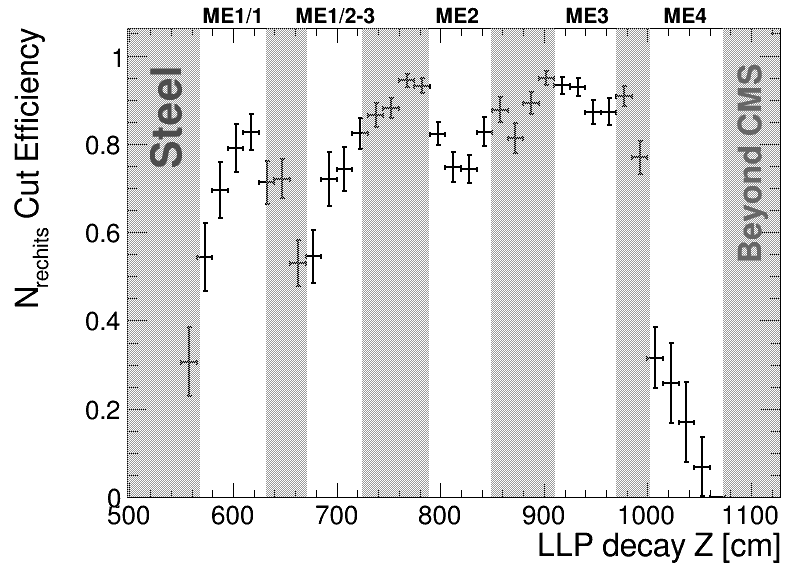

In [31]:
import numpy.ma as ma
import ROOT as rt
import os

names = ['cluster_efficiency', 'sig_eff', 'nRechit_efficiency']
m = '15'
for name in names:
    for r in [0,1]:
        if r == 1:continue
#         if not name == 'cluster_efficiency':continue
        c = rt.TCanvas('c','c', 800, 600)
        if r:
            bins = [20,100,700]
            xaxis_title = 'LLP decay R [cm]'
        else:
            bins = [35, 550, 1075]
            xaxis_title = 'LLP decay Z [cm]'

            # hm = create_TH1D(cscRechitCluster_match_gLLP_r[eta.flatten()==True].flatten(), 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        # hb = create_TH1D(cscRechitCluster_match_gLLP_r.flatten(), 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        if r:
            if name == 'cluster_efficiency':
                hm = create_TH1D(r_denom[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[m])
                hb = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
            elif name == 'sig_eff':
                hm = create_TH1D(r_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                hb = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
            else:
                hm = create_TH1D(r_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                hb = create_TH1D(r_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])
        else:
        #     if name == 'cluster_efficiency':hm = create_TH1D(z_denom, 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        #     else: hm = create_TH1D(z_nom, 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        #     hb = create_TH1D(llp_z, 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
            if name == 'cluster_efficiency':
                hm = create_TH1D(z_denom[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[m])
                hb = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
            elif name == 'sig_eff':
                hm = create_TH1D(z_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                hb = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
            else:
                hm = create_TH1D(z_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                hb = create_TH1D(z_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])


        print(hm.Integral()/hb.Integral(), len(z_denom)/len(llp_z), len(r_denom)/len(llp_r))

        pEff1 = rt.TEfficiency(hm,hb)
        pEff1.SetLineColor(std_color_list[0])
        pEff1.SetLineWidth(2)
        pEff1.Draw()

        c.Draw()


        ymax = pEff1.GetPaintedGraph().GetHistogram().GetMaximum()
        ymin = pEff1.GetPaintedGraph().GetHistogram().GetMinimum()
        xmin = pEff1.GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
        xmax = pEff1.GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()

        print()
        if r:
            l = rt.TLine(350,ymin, 350, ymax)
            l.SetLineWidth(2)
            l.SetLineStyle(2)
            l.Draw()
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(150, ymax*0.94, "Inner ring")
            text.DrawLatex(400, ymax*0.94, "Outer ring")
        else:
            boxes = []

            boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
            boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
            boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
            boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
            boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
            boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
            for b in boxes:
                b.SetFillColor(15)
                b.SetFillStyle(3001)
                b.Draw('same')
            l = rt.TLatex()
            l.SetTextSize(0.08)
            l.SetTextColor(12)
            l.SetTextAngle(90)
            l.DrawLatex(550, ymax*0.7, "Steel")
            l2 = rt.TLatex()
            l2.SetTextSize(0.06)
            l2.SetTextColor(13)
            l2.SetTextAngle(90)
            l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(570, ymax*1.01, "ME1/1")
            text.DrawLatex(660, ymax*1.01, "ME1/2-3")
            text.DrawLatex(795, ymax*1.01, "ME2")
            text.DrawLatex(920, ymax*1.01, "ME3")
            text.DrawLatex(1015, ymax*1.01, "ME4")

        if cut_based: bdt_name = "cut_based_"+cut_based_version
        print(bdt_name)
        outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
        if not os.path.isdir(outDir):os.makedirs(outDir)
        if r:
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+".png")
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+".pdf")
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+".C")
        else:
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+".png")
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+".pdf")
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+".C")




# Efficiency vs. Decay position (2D)

0.19611930510604017 1.0 1.0
0.6651202167470665 0.08698529256074121
137 fb^{-1} (13 TeV)
21 21
cut_based_v4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal
Info in <TCanvas::SaveSource>: C++ Macro file: ../../plots/MuonSystem_Analysis/cut_based_v4/v1/v108/2D_sig_eff_m15.C has been generated
Info in <TCanvas::Print>: png file ../../plots/MuonSystem_Analysis/cut_based_v4/v1/v108/2D_sig_eff_m15.png has been created
Info in <TCanvas::Print>: pdf file ../../plots/MuonSystem_Analysis/cut_based_v4/v1/v108/2D_sig_eff_m15.pdf has

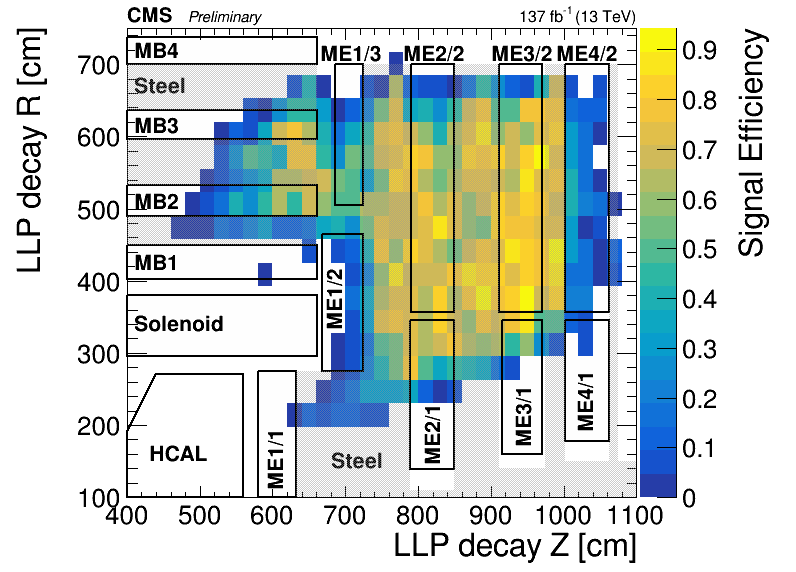

In [89]:
import numpy.ma as ma
import ROOT as rt
import os

names = ['sig_eff']
m = '15'
  
c = rt.TCanvas('c','c', 800, 600)
bins = [35, 400, 1100, 20,100,750]
# bins = [10,100,700, 20, 550, 1075]


title = ['LLP decay R [cm]', 'LLP decay Z [cm]']

hm = create_TH2D(np.column_stack((z_nom[m],r_nom[m])), 'hm1', axis_title = [title[1], title[0], 'Signal Efficiency'], binning=bins, weights = weight_nom[m])
hb = create_TH2D(np.column_stack((llp_z[m],llp_r[m])), 'hb1', axis_title = [title[1], title[0],'Signal Efficiency'], binning=bins, weights = weight_llp[m])


print(hm.Integral()/hb.Integral(), len(z_denom)/len(llp_z), len(r_denom)/len(llp_r))

pEff1 = rt.TEfficiency(hm,hb)
print(pEff1.GetEfficiency(500), pEff1.GetEfficiencyErrorUp(500))
#     pEff1.SetLineColor(std_color_list[0])
#     pEff1.SetLineWidth(2)
pEff1.Draw('colz')
c.SetRightMargin(0.2)
c.Draw()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, 0)
CMS_lumi.CMS_lumi(c, 4, iPos)



text = rt.TLatex()
text.SetTextSize(0.04)


text.DrawLatex(665, 705, "ME1/3")



text.DrawLatex(780, 705, "ME2/2")
text.DrawLatex(900, 705, "ME3/2")
text.DrawLatex(990, 705, "ME4/2")

text.DrawLatex(410, 415, "MB1")
text.DrawLatex(410, 500, "MB2")
text.DrawLatex(410, 605, "MB3")
text.DrawLatex(410, 708, "MB4")

text.DrawLatex(680, 140, "Steel")
text.DrawLatex(410,660, "Steel")
text.DrawLatex(410, 330, "Solenoid")
text.DrawLatex(430, 150, "HCAL")

text.SetTextAngle(90)
text.DrawLatex(615, 110, "ME1/1")
text.DrawLatex(695, 331, "ME1/2")
text.DrawLatex(830, 145, "ME2/1")
text.DrawLatex(955, 170, "ME3/1")
text.DrawLatex(1040, 190, "ME4/1")









boxes = []
boxes.append(rt.TBox(400,402,661,449)) #MB1
boxes.append(rt.TBox(400,490,661,533)) #MB2
boxes.append(rt.TBox(400,597,661,636)) #MB3
boxes.append(rt.TBox(400,700,661,738)) #MB4

boxes.append(rt.TBox(400,295,661,380)) #solenoid


boxes.append(rt.TBox(791,357,850,700)) #ME2/2
boxes.append(rt.TBox(911,357,970,700)) #ME3/2
boxes.append(rt.TBox(1002,357,1063,700)) #ME4/2

boxes.append(rt.TBox(789,139,850,345)) #ME2/1
boxes.append(rt.TBox(915,160,970,345)) #ME3/1
boxes.append(rt.TBox(1002,178,1063,345)) #ME4/1

boxes.append(rt.TBox(580,100,632,275)) #ME1/1
boxes.append(rt.TBox(668,275,724,465)) #ME1/2
boxes.append(rt.TBox(686,505,724,700)) #ME1/3
boxes.append(create_TGraph([400.5,560,560,440,400.5,400.5],[100.5,100.5,270,270,190,100.5])) #hcal

for b in boxes:
    b.SetFillColorAlpha(15,0)
    b.SetLineWidth(2)
    b.SetLineColor(1)
#     b.SetFillStyle(3001)
    b.Draw('l same')

steel = []
steel.append(rt.TBox(400,449,661,490)) #MB1
steel.append(rt.TBox(400,533,661,597)) #MB2
steel.append(rt.TBox(400,636,661,700)) #MB3
x=[633,633, 1100, 1100, 1075, 1075, 1063, 1063,1002,1002,975,975,912,912,849,849,789,789,724,724, 633]
y=[275, 100, 100, 150, 150, 700,700,150,150,700,700,140,140,700,700,110,110,700,700,275,275]
print(len(x),len(y))
steel.append(create_TGraph(x,y)) 



for b in steel:
    b.SetFillColorAlpha(15,0.5)
    b.SetFillStyle(3001)
#     b.SetFillColorAlpha(15,0.1)
    b.Draw('fsame')


if cut_based: bdt_name = "cut_based_"+cut_based_version
print(bdt_name)
outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
if not os.path.isdir(outDir):os.makedirs(outDir)
c.SaveAs(outDir+"2D_sig_eff_m"+m+".C")
c.SaveAs(outDir+"2D_sig_eff_m"+m+".png")
c.SaveAs(outDir+"2D_sig_eff_m"+m+".pdf")



In [ ]:
st = tdrstyle.setTDRStyle()



# all mass points

0.7873868033618728 0.7670046994805837 0.7670046994805837
0.8206696134066974 0.7969793986636972 0.7969793986636972
0.8314294232515538 0.8083234244946492 0.8083234244946492

cut_based_v4
0.7680359800740263 0.7670046994805837 0.7670046994805837
0.7975555404608597 0.7969793986636972 0.7969793986636972
0.8094402892794881 0.8083234244946492 0.8083234244946492

cut_based_v4
0.30159533224961255 0.7670046994805837 0.7670046994805837
0.2918197996088982 0.7969793986636972 0.7969793986636972
0.2716998961015295 0.8083234244946492 0.8083234244946492

cut_based_v4
0.294183323369246 0.7670046994805837 0.7670046994805837
0.2836007257879486 0.7969793986636972 0.7969793986636972
0.26449967480659947 0.8083234244946492 0.8083234244946492

cut_based_v4
0.8286179587667978 0.7670046994805837 0.7670046994805837
0.8478436241185866 0.7969793986636972 0.7969793986636972
0.8535898119050582 0.8083234244946492 0.8083234244946492

cut_based_v4
0.8286179587667978 0.7670046994805837 0.7670046994805837
0.847843624118586

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing effici

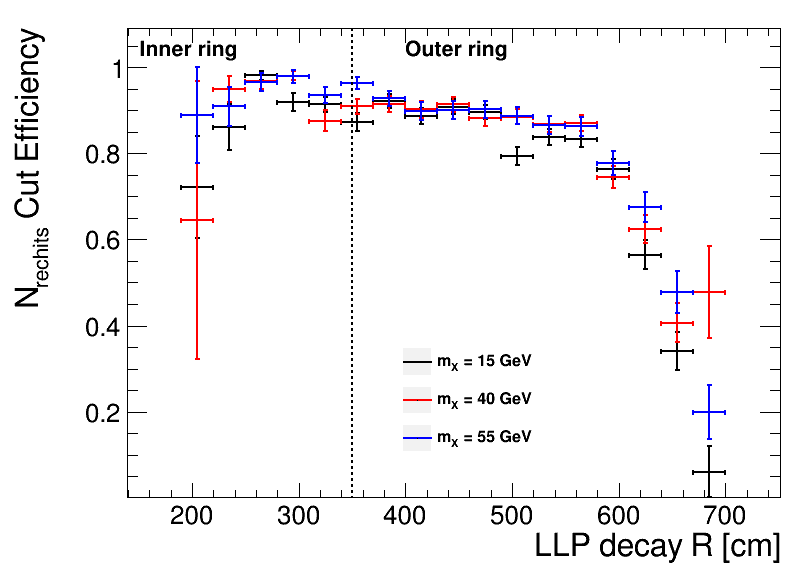

In [16]:
import numpy.ma as ma
import ROOT as rt
import os

names = ['cluster_efficiency', 'sig_eff', 'nRechit_efficiency']

for name in names:
#     if not name == 'sig_eff':continue
    for r in [0,1]:
#         if r == 1:continue
        c = rt.TCanvas('c','c', 800, 600)
        if 'cluster' in name: leg = rt.TLegend(0.24,0.2,0.4,0.4)
        elif 'sig_eff' in name:leg = rt.TLegend(0.24,0.65,0.4,0.85)
        else:leg = rt.TLegend(0.5,0.2,0.7,0.4)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        if r:
            bins = [20,100,700]
            xaxis_title = 'LLP decay R [cm]'
        else:
            bins = [35, 550, 1075]
            xaxis_title = 'LLP decay Z [cm]'
        hm = {}
        hb = {}
        pEff1 = {}
        for i, m in enumerate(r_denom.keys()):
            if r:
                if name == 'cluster_efficiency':
                    hm[m] = create_TH1D(r_denom[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[m])
                    hb[m] = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                elif name == 'sig_eff':
                    hm[m] = create_TH1D(r_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                    hb[m] = create_TH1D(llp_r[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                else:
                    hm[m] = create_TH1D(r_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                    hb[m] = create_TH1D(r_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])
            else:
                if name == 'cluster_efficiency':
                    hm[m] = create_TH1D(z_denom[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[m])
                    hb[m] = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                elif name == 'sig_eff':
                    hm[m] = create_TH1D(z_nom[m], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[m])
                    hb[m] = create_TH1D(llp_z[m], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[m])
                else:
                    hm[m] = create_TH1D(z_nRechits[m], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[m])
                    hb[m] = create_TH1D(z_nom[m], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[m])


            print(hm[m].Integral()/hb[m].Integral(), len(z_denom[m])/len(llp_z[m]), len(r_denom[m])/len(llp_r[m]))

            pEff1[m] = rt.TEfficiency(hm[m],hb[m])
            pEff1[m].SetLineColor(std_color_list[i])
            leg.AddEntry(pEff1[m],"m_{X} = "+m+" GeV")


            pEff1[m].SetLineWidth(2)
            pEff1[m].Draw('' if i == 0 else 'same')

        c.Draw()


        ymax = pEff1['15'].GetPaintedGraph().GetHistogram().GetMaximum()
        ymin = pEff1['15'].GetPaintedGraph().GetHistogram().GetMinimum()
        xmin = pEff1['15'].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
        xmax = pEff1['15'].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()

        print()
        if r:
            l = rt.TLine(350,ymin, 350, ymax)
            l.SetLineWidth(2)
            l.SetLineStyle(2)
            l.Draw()
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(150, ymax*0.94, "Inner ring")
            text.DrawLatex(400, ymax*0.94, "Outer ring")
        else:
            boxes = []

            boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
            boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
            boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
            boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
            boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
            boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
            for b in boxes:
                b.SetFillColor(15)
                b.SetFillStyle(3001)
                b.Draw('same')
            l = rt.TLatex()
            l.SetTextSize(0.08)
            l.SetTextColor(12)
            l.SetTextAngle(90)
            l.DrawLatex(550, ymax*0.7, "Steel")
            l2 = rt.TLatex()
            l2.SetTextSize(0.06)
            l2.SetTextColor(13)
            l2.SetTextAngle(90)
            l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(570, ymax*1.01, "ME1/1")
            text.DrawLatex(660, ymax*1.01, "ME1/2-3")
            text.DrawLatex(795, ymax*1.01, "ME2")
            text.DrawLatex(920, ymax*1.01, "ME3")
            text.DrawLatex(1015, ymax*1.01, "ME4")
        leg.Draw()


        if cut_based: bdt_name = "cut_based_"+cut_based_version
        print(bdt_name)
        outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version+'/'
        if not os.path.isdir(outDir):os.makedirs(outDir)
        if r:
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_mcomp.png")
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_mcomp.C")
        else:
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_mcomp.png")
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_mcomp.C")





# year comparison

In [30]:
%%time
import uproot
import numpy as np
cut_based = True
cut_based_version='v4'
r_denom = {}
z_denom = {}
r_nom = {}
z_nom = {}
r_nRechits = {}
z_nRechits = {}
weight_nom = {}
weight_denom = {}
weight_nRechits = {}
llp_r = {}
llp_z ={}
weight_llp = {}

m = '15'
lumi = [ 35.9, 41.5, 59.7 ]
years = ["MC_Summer16", "MC_Fall17", "MC_Fall18"]
for i, year in enumerate(years):
    analyzer_version = '/v1/v86/'
    path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/"+year+analyzer_version+"/normalized/"
    root_dir =uproot.open(path+"ggH_HToSSTobbbb_MH-125_MS-"+m+".root")
    T = root_dir['MuonSystem']
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 1
    sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
    sel_ev = np.logical_and(sel_ev ,T.array('met') >= 200)
    sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
    sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_llp = T.array('gLLP_csc')[sel_ev] == 1

    llp_r[year] = np.abs(T.array('gLLP_decay_vertex_r'))[sel_ev][sel_llp]
    llp_z[year] = np.abs(T.array('gLLP_decay_vertex_z'))[sel_ev][sel_llp]
    weight_llp[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i]

    cluster_index = '3'

    ########### SELECTION: CLUSTERS ############
    sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)

    r_denom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()
    z_denom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()
    weight_denom[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev]*lumi[i]


    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster'+cluster_index+'Time') > -5.0, T.array('cscRechitCluster'+cluster_index+'Time') < 12.5))
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.1)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0)

    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_MB1_0p4') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)



    ##### bdt variables ####


    cscRechitClusterEta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev].flatten()
    cscRechitClusterPhi = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_rechitcluster][sel_ev].flatten()
    cscRechitClusterAvgStation10 = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_rechitcluster][sel_ev].flatten()
    cscRechitClusterNStation10 = T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_rechitcluster][sel_ev].flatten()



    if cut_based_version == 'v4':
        cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==2, np.abs(cscRechitClusterEta) < 1.6)
        cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==3, np.abs(cscRechitClusterEta) < 1.6)
        cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10)==4, np.abs(cscRechitClusterEta) < 1.8)
        cond1 = np.logical_and(cscRechitClusterNStation10==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10)==1, cond2), np.logical_or(cond3, cond4)))
        cond2 = np.logical_and(cscRechitClusterNStation10 > 1, np.abs(cscRechitClusterEta) < 1.9)
        bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    else:print("ERROR")

    r_nom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel]
    z_nom[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel]
    weight_nom[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel]*lumi[i]
    
    nRechitscut = T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev].flatten()[bdt_sel]

    r_nRechits[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130]
    z_nRechits[year] = np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z'))[sel_rechitcluster][sel_ev].flatten()[bdt_sel][nRechitscut>=130]
    weight_nRechits[year] = (T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][bdt_sel][nRechitscut>=130]*lumi[i]

CPU times: user 1.12 s, sys: 25 ms, total: 1.14 s
Wall time: 1.43 s


# plotting

cut_based_v4
cut_based_v4
cut_based_v4
cut_based_v4
cut_based_v4
cut_based_v4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing effici

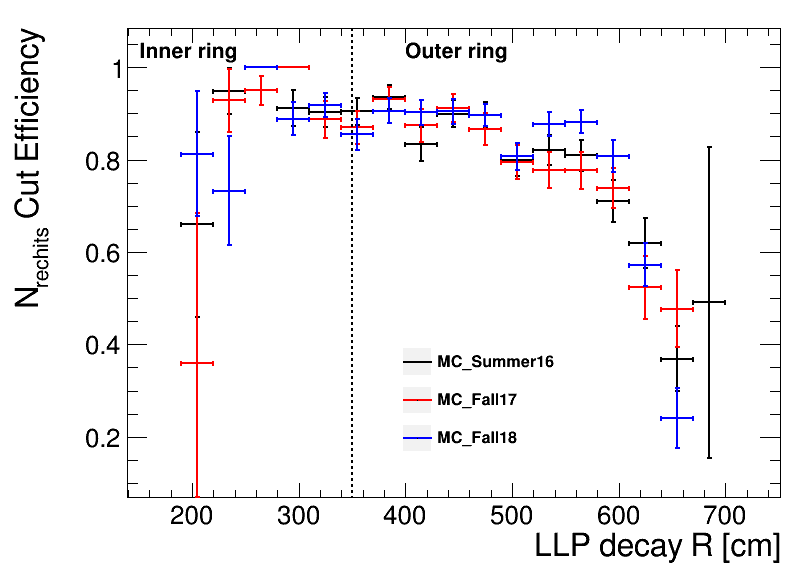

In [31]:
import numpy.ma as ma
import ROOT as rt
hm = {}
hb = {}
pEff1 = {}
names = ['cluster_efficiency', 'sig_eff', 'nRechit_efficiency']

for name in names:
    for r in [0,1]:
#         if not  name == 'sig_eff':continue
        c = rt.TCanvas('c','c', 800, 600)
        if 'cluster' in name: leg = rt.TLegend(0.24,0.2,0.4,0.4)
        elif 'sig_eff' in name:leg = rt.TLegend(0.24,0.65,0.4,0.85)
        else:leg = rt.TLegend(0.5,0.2,0.7,0.4)
        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        if r:
            bins = [20,100,700]
            xaxis_title = 'LLP decay R [cm]'
        else:
            bins = [35, 550, 1075]
            xaxis_title = 'LLP decay Z [cm]'

            # hm = create_TH1D(cscRechitCluster_match_gLLP_r[eta.flatten()==True].flatten(), 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        # hb = create_TH1D(cscRechitCluster_match_gLLP_r.flatten(), 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins)
        for i, k in enumerate(years):
            if r:
                if name == 'cluster_efficiency':
                    hm[k] = create_TH1D(r_denom[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[k])
                    hb[k] = create_TH1D(llp_r[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                elif name == 'sig_eff':
                    hm[k] = create_TH1D(r_nom[k], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[k])
                    hb[k] = create_TH1D(llp_r[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                else:
                    hm[k] = create_TH1D(r_nRechits[k], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[k])
                    hb[k] = create_TH1D(r_nom[k], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[k])
            else:

                if name == 'cluster_efficiency':
                    hm[k] = create_TH1D(z_denom[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_denom[k])
                    hb[k] = create_TH1D(llp_z[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                elif name == 'sig_eff':
                    hm[k] = create_TH1D(z_nom[k], 'hm1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_nom[k])
                    hb[k] = create_TH1D(llp_z[k], 'hb1', axis_title = [xaxis_title,'Signal Efficiency'], binning=bins, weights = weight_llp[k])
                else:
                    hm[k] = create_TH1D(z_nRechits[k], 'hm1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nRechits[k])
                    hb[k] = create_TH1D(z_nom[k], 'hb1', axis_title = [xaxis_title,'N_{rechits} Cut Efficiency'], binning=bins, weights = weight_nom[k])

            pEff1[k] = rt.TEfficiency(hm[k],hb[k])
            pEff1[k].SetLineColor(std_color_list[i])
            pEff1[k].SetLineWidth(2)
            leg.AddEntry(pEff1[k],k)
            pEff1[k].Draw('' if i == 0 else 'same')
        
        c.Draw()


        ymax = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetMaximum()
        ymin = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetMinimum()
        xmin = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
        xmax = pEff1[years[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()

        if r:
            l = rt.TLine(350,ymin, 350, ymax)
            l.SetLineWidth(2)
            l.SetLineStyle(2)
            l.Draw()
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(150, ymax*0.94, "Inner ring")
            text.DrawLatex(400, ymax*0.94, "Outer ring")
        else:
            boxes = []

            boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
            boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
            boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
            boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
            boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
            boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
            for b in boxes:
                b.SetFillColor(15)
                b.SetFillStyle(3001)
                b.Draw('same')
            l = rt.TLatex()
            l.SetTextSize(0.08)
            l.SetTextColor(12)
            l.SetTextAngle(90)
            l.DrawLatex(550, ymax*0.7, "Steel")
            l2 = rt.TLatex()
            l2.SetTextSize(0.06)
            l2.SetTextColor(13)
            l2.SetTextAngle(90)
            l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
            text = rt.TLatex()
            text.SetTextSize(0.04)
            text.DrawLatex(570, ymax*1.01, "ME1/1")
            text.DrawLatex(660, ymax*1.01, "ME1/2-3")
            text.DrawLatex(795, ymax*1.01, "ME2")
            text.DrawLatex(920, ymax*1.01, "ME3")
            text.DrawLatex(1015, ymax*1.01, "ME4")
        leg.Draw()
        if cut_based: bdt_name = "cut_based_"+cut_based_version
        print(bdt_name)
        outDir = "../../plots/MuonSystem_Analysis/"+bdt_name+analyzer_version
        if not os.path.isdir(outDir):os.makedirs(outDir)
        if r:
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_yComp.png")
            c.SaveAs(outDir+name+"_r_denomAllLLP_m"+m+"_yComp.C")
        else:
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_yComp.png")
            c.SaveAs(outDir+name+"_z_denomAllLLP_m"+m+"_yComp.C")


